# Tema 4: model de regresie logistica multinomiala antrenat cu Pytorch

Implementati un model de regresie logistica multinomiala pentru clasificarea celor 10 tipuri de cifre din setul MNIST.

Puteti reutiliza si adapta cod din exemplul Pytorch pentru regresia logistica binara. 
Modificarile pe care trebuie sa le aveti in vedere sunt:
1. in definirea lui Dataset nu se mai face filtrare dupa clasele pozitive si negative; se lasa toate datele
1. In definirea clasei modelului, stratul `self.fully_connected` trebuie sa fie cu numarul de iesiri egal cu numarul de clase
1. La predictie, pentru fiecare vector de intrare (cifra reprezentata ca vector de 784 de valori) modelul produce un vector de 10 probabilitati. Clasa se decide ca indicele pe care probabilitatea este maxima. Aceasta afecteaza implementarea functiei de testare
1. Se reccomanda ca in functia `forward` a modelului sa nu se mai aplice si functia softmax, ci sa se returneze direct logitii (valoarea producsa de aplicarea stratului liniar, adica inmultirea dintre matricea de ponderi si intrare)
1. Functia de eroare `loss_fn` este `torch.nn.CrossEntropyLoss`. Aceasta preia logitii produsi de model (punctul de mai sus)

Creati o matrice de confuzie pentru clase; puteti folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Folositi unul din optimizatorii: Adam, RMSprop, Adagrad.

Prezentati in acelasi grafic loss-ul pe setul antrenare si pe testare; intr-un alt grafic acuratetea pe setul de antrenare si pe cel de testare.

Predarea acestei aplicatii se pana in 10 aprilie ora 23, in cadrul temei 4 de pe platforma. Modul de predare si de rpezentare aeste la fel ca pentru temele precedente.

## Importarea pachetelor necesare 

In [72]:
import torch # pentru a folosi PyTorch in acest notebook 
import torch.nn as nn # pentru a folosi modulul de retele neurale
import torch.nn.functional as F # pentru a folosi functii de activare
from torchvision import datasets, transforms # pentru a folosi setul de date MNIST si transformari de date, precum normalizarea 

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.2+cu121  Device: cuda


In [73]:
from torchinfo import summary # pentru a afisa un sumar al retelei neurale, adica arhitectura
#retelei, numarul de parametri si dimensiunile tensorilor de iesire ale fiecarui strat din retea etc

## Pregatirea setului de date: clasa de tip Dataset

In [74]:
# importam clasa de baza Dataset:
from torch.utils.data import Dataset # pentru a crea o clasa custom de set de date

In [75]:
# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd # Pandas poate citi și scrie date din și către o varietate largă
#de formate de fișiere, cum ar fi CSV
import os # pentru a lucra cu fisiere si directoare
from typing import Tuple 

In [104]:
#aceasta functie va fi folosita pentru a afisa o imagine din setul de date MNIST 
class MNISTDataset(Dataset): # clasa derivata din clasa Dataset
    def __init__(self, path_csv: str): # constructorul clasei care primeste calea catre fisierul csv cu datele
        """
        Initializes the dataset by reading the contents of the CSV file at the specified path.
        :param path_csv: path to the CSV file containing the dataset.

        """
        
         #îi spui lui super() că vrei să referințiezi clasa părinte a MNISTDataset si să utilizeze această instanță curentă pentru a accesa metodele clasei părinte
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte 
        super(MNISTDataset, self).__init__() # folosesc super() pentru a accesa metoda __init__ a clasei părinte;necesar pentru a accesa atributele și metodele clasei de bază

        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indică spre un fișier'
        self.path_csv = path_csv # calea catre fisierul csv cu datele

        _all_digits = pd.read_csv(path_csv, header=None).values # citim datele din fisierul csv si le stocam in _all_digits ca np.array; values returneaza un numpy array
        # valorile de intrare in x, etichetele in y 
        _y = _all_digits[:, 0] # prima coloana contine etichetele (cifrele de la 0 la 9)
        _x = _all_digits[:, 1:] # restul coloanelor contin valorile de intrare (imaginile)
        # valorile 0..255 din setul de intrare _x sunt scalate la 0..1 
        #previne divergenta in reteaua neurala => actualizările ponderilor vor fi mult prea mari
        _x = _x / 255 # normalizam datele de intrare. daca nu faceam asta, reteaua ar fi avut dificultati in invatare 

        # convertim din numpy array in torch tensors:
        self.x = torch.tensor(_x, dtype=torch.float32) # tensorul de intrare
        self.y = torch.tensor(_y, dtype=torch.int64)  # tensorul de etichete
     
    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.
        :return: number of samples in the dataset.
        """
        return len(self.y) # returnam numarul de etichete, adica numarul de mostre din setul de date 
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the sample from the dataset at the specified index.
        :param index: index of the sample to return.
        :return: the sample from the dataset at the specified index.
        """
        return self.x[index], self.y[index] # returnam perechea de intrare si eticheta de la indexul specificat

In [ ]:
#Un mini-batch este un subset mic din întregul set de date utilizat pentru a antrena un model în procesul de învățare automată
#diferenta principala intre deep learning si machine learning este ca deep learning foloseste retele neurale pentru a invata, iar machine learning foloseste algoritmi pentru a invata 
#"Ajustarea ponderilor" înseamnă că schimbi greutățile (le faci mai grele sau mai ușoare) pentru a echilibra balanța corect, astfel încât când pui date noi pe ea, să încline în direcția corectă.

In [77]:
#două seturi separate: unul pentru a învăța modelul și celălalt pentru a verifica cât de bine funcționează acesta după ce a fost antrenat.

train_ds = MNISTDataset('./data/mnist_train.csv') # instantiem clasa MNISTDataset cu calea catre fisierul csv cu datele de antrenare
test_ds = MNISTDataset('./data/mnist_test.csv') # instantiem clasa MNISTDataset cu calea catre fisierul csv cu datele de testare

assert len(train_ds) == 60000 # verificam daca setul de date de antrenare are 60000 de mostre; 
assert len(test_ds) == 10000 # verificam daca setul de date de testare are 10000 de mostre



# Antrenamentul necesită mai multe date: Setul de antrenament este mare (60,000 de mostre) pentru că ai nevoie de cât mai multe exemple pentru a 
# "învăța" modelul. Cu cât modelul vede mai multe exemple, cu atât învață mai bine cum arată cifrele de la 0 la 9 și cum să le deosebească. Este ca și cum
# te-ai pregăti pentru un examen; cu cât exersezi mai mult, cu atât ești mai pregătit.

# Testarea necesită mai puține date: Setul de testare este mai mic (10,000 de mostre) și este folosit doar pentru a verifica cât de bine a învățat modelul. 
# Nu ai nevoie de la fel de multe date pentru testare ca în cazul antrenării. Este ca și cum, după ce ai învățat pentru examen, dai un test scurt pentru a vedea dacă poți aplica ce ai învățat.

# Evitarea overfitting-ului: Dacă folosești prea multe date pentru testare și prea puține pentru antrenament, riscă să nu ai suficiente informații pentru a învăța modelul adecvat.
#  În plus, dacă modelul ar vedea prea des datele de testare, ar putea începe să "învețe pe de rost" răspunsurile corecte, ceea ce nu ajută atunci când întâlnește date noi.

## Incarcarea datelor folosind un DataLoader

In [78]:
from torch.utils.data import DataLoader # pentru a incarca datele in mini-batch-uri;
 #în loc să procesezi fiecare exemplu individual, poți procesa un grup de exemple la un timp, ceea ce este mai eficient din punct de vedere computațional.

In [79]:
#Procesoarele moderne și unitățile de procesare grafică (GPU) sunt optimizate pentru a lucra eficient cu dimensiuni de date care sunt puteri ale lui 2.
#DataLoader împarte setul de date în partiții de dimensiune egală conform valorii batch_size
batch_size = 32 # in functie de memoria disponibila pe GPU ;Dimensiunea unui batch, adică numărul de exemple de date procesate împreună într-un singur pas de antrenament
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # incarcam datele de antrenare in mini-batch-uri; shuffle = True pentru a amesteca datele pt preventia overfitting-ului
test_loader = DataLoader(test_ds, batch_size=batch_size)

# pentru primul minibatch tiparim 'shape' (dimensiunea) datelor de intrare si etichetelor
# datele de intrare ar tb sa fie un tensor de forma (batch_size x 784)  
# etichetele ar trebui sa fie un tensor de forma batch_size 
for data, label in train_loader: # iteram prin train_loader
    print(data.shape, label.shape) # afisam dimensiunile datelor de intrare si etichetelor
    break # ne oprim dupa primul minibatch

# restul de minibatchuri arata la fel, eventual exceptand ultimul minibatch care poate avea mai putine exemple
# De exemplu, să presupunem că ai un set de date cu 100 de exemple și alegi un batch_size de 32. 
# Atunci, primele trei minibatch-uri vor conține fiecare 32 de exemple, iar ultimul minibatch va conține restul, adică 4 exemple
# . Aceasta este excepția menționată: dimensiunea ultimului minibatch poate fi mai mică decât celelalte minibatch-uri.



torch.Size([32, 784]) torch.Size([32])


## Definirea modelului

In [80]:
# se definește un model de regresie logistică multinomială folosit pentru clasificare, care este implementat ca o rețea neurală în PyTorch.
class MultinomialLogisticRegression(nn.Module): # clasa derivata din clasa nn.Module, care este clasa de baza pentru toate retelele neurale din PyTorch
    def __init__(self, input_size: int = 784, num_classes: int = 10): # constructorul clasei, care primeste dimensiunea datelor de intrare si numarul de clase
        """
        Initialize the model by setting up the linear layer.
        :param input_size: The size of the input features.
        :param num_classes: The size of the output classes.
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super(MultinomialLogisticRegression, self).__init__() # folosesc super() pentru a accesa metoda __init__ a clasei părinte;necesar pentru a accesa atributele și metodele clasei de bază 
        self.input_size = input_size # numărul de caracteristici sau de elemente din fiecare exemplu de date. În cazul nostru, fiecare exemplu de date are 784 de elemente, deoarece fiecare imagine are 28x28 pixeli.
        self.num_classes = num_classes # numărul de clase în care putem clasifica fiecare exemplu de date. În cazul nostru, avem 10 clase, deoarece avem cifre de la 0 la 9.
        # Initializam ponderile ca o matrice de input_size x num_classes elemente
        # matrice = operator liniar
        self.fully_connected = nn.Linear(input_size, num_classes) # un strat liniar care primeste input_size si returneaza num_classes; folosit pt clasificare
        #Deci, pentru clasificarea imaginilor MNIST, ai un singur strat liniar cu 784 de intrări (pixeli) și 10 neuroni de ieșire. 
        #Fiecare neuron din acest strat liniar va produce un scor asociat cu una dintre cele 10 clase posibile (cifrele de la 0 la 9).


    # forward este metoda care defineste cum datele sunt propagate prin reteaua neurala, mai simplu spus, cum sunt clasificate datele
    def forward(self, x):
        """
        Propagate the input through the network, with a view to classifying the input.
        :param x: The input data.
        :return: The classification scores.
        """
        # Se propaga dinspre stratul de intrare spre stratul liniar
        x = self.fully_connected(x) # fiecare valoare de intrare este înmulțită cu o anumită pondere și apoi adăugată la un termen de bias.  => scorul de clasificare 
        return x

In [ ]:
# nu alegeți manual bias-ul, ci lăsați rețeaua neurală să-l învețe în timpul antrenamentului, astfel încât să se potrivească optim cu datele și să facă predicții precise.
#Imaginați-vă că sunteți la o întâlnire unde oamenii au înălțimi diferite. Dacă încercați să estimați înălțimea medie a persoanelor prezente fără să luați în considerare o valoare de bază sau un punct de referință, 
#cum ar fi 0 (adică fără bias), estimarea dvs. ar fi distorsionată. Este posibil să subestimați sau să supraestimați înălțimea medie, deoarece nu luați în considerare variabilitatea înălțimilor individuale.

# Însă, dacă adăugați un "bias" la estimarea dvs., acesta ar reprezenta un fel de "punct de plecare" sau "o estimare inițială" a înălțimii medii. 
# Acest lucru vă permite să ajustați estimarea pentru a se potrivi mai bine cu realitatea. De exemplu, dacă presupuneți inițial că media înălțimii este 160 de centimetri,
# puteți ajusta această estimare în sus sau în jos în funcție de înălțimile reale observate la întâlnire.

#deci bias-ul este un termen constant adăugat la rezultatul unei operații de multiplicare a ponderilor cu intrările. el previne subestimarea sau supraestimarea rezultatelor

In [82]:
model = MultinomialLogisticRegression(input_size=784) # instantiem modelul de regresie logistica multinomiala cu dimensiunea datelor de intrare 784 
print(model) # afisam modelul , adica arhitectura retelei neurale 

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)


In [83]:
summary(model,input_size=(1, 784)) # afisam un sumar al retelei neurale, adica arhitectura retelei, numarul de parametri si dimensiunile tensorilor de iesire ale fiecarui strat din retea etc

Layer (type:depth-idx)                   Output Shape              Param #
MultinomialLogisticRegression            [1, 10]                   --
├─Linear: 1-1                            [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [ ]:
#7,850=784×10+10 (10 bias-uri pentru fiecare din cele 10 clase)

# Trainable params sunt parametrii dintr-un model neuronal care sunt ajustați (actualizați) în timpul antrenamentului.
# Acești parametri sunt cei care învață din datele de antrenament pentru a îmbunătăți performanța modelului.
# Un exemplu ar fi ponderile și bias-urile din straturile fully connected sau convolutional ale unei rețele neurale.

# Non-trainable params sunt parametrii care nu sunt ajustați în timpul antrenamentului și rămân fixați. 
# Acești parametri sunt de obicei pre-antrenați sau predefiniți și nu sunt actualizați pentru problema specifică pentru care este antrenat modelul.
# Un exemplu ar fi parametrii unei rețele neurale pre-antrenate utilizate în transfer learning, unde stratul de extragere a caracteristicilor este înghețat și nu este ajustat,
# iar doar straturile ulterioare sunt antrenate pentru o anumită sarcină.

# Atunci când Total mult-adds este foarte mic, înseamnă că rețeaua neurală este relativ simplă sau că dimensiunile și complexitatea datelor de intrare sunt reduse. 
# Prin urmare, cantitatea de calcul necesară pentru a efectua propagarea înainte și înapoi prin rețea este mică.
# Astfel, un Total mult-adds foarte mic sugerează că rețeaua neurală este ușor de antrenat și poate fi executată rapid pe diferite dispozitive hardware,
# cum ar fi procesoarele CPU sau unitățile de procesare grafică (GPU).




# Output Shape: Arată forma ieșirii modelului, care este un vector linie cu 10 elemente, indicând scorurile de clasificare pentru cele 10 clase posibile.
# Parametrii: Acesta indică numărul total de parametri din model, inclusiv ponderile și bias-urile. În cazul nostru, avem 7,850 de parametri.
# Total params: Este numărul total de parametri ai modelului, care este, de asemenea, 7,850.
# Trainable params: Aici se indică numărul de parametri care vor fi ajustați în timpul antrenamentului. În cazul nostru, toți cei 7,850 de parametri sunt ajustabili.
# Non-trainable params: Nu avem parametri care să fie non-trainable.
# Total mult-adds: Este numărul total de operații de multiplicare și adunare efectuate în timpul propagării înainte și înapoi prin rețea. În acest caz, este foarte mic, de 0.01 MB, indicând o cantitate mică de calcul.

In [84]:
print(f'device={device}') 
model.to(device) # mutam modelul pe device-ul specificat (GPU sau CPU) deoarece PyTorch nu face asta automat

device=cuda


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
)

## Antrenarea modelului

In [85]:
# dezactivam urmarirea automata a tensorilor pentru care se pot calcula gradienti:
# gradientii sunt folositi doar la antrenare, nu si la testare
# Când dezactivăm urmărirea automată a tensorilor pentru care se pot calcula gradienți, ne asigurăm că nu reținem informațiile necesare pentru a ajusta parametrii modelului.
# Astfel, economisim memorie și putere de calcul, deoarece nu trebuie să facem calcule suplimentare în timpul testării modelului.
# În esență, este ca și cum am spune modelului să se concentreze doar pe sarcina de testare,
# fără să se îngrijoreze de actualizarea parametrilor pentru antrenament.
@torch.no_grad()  
#în mod implicit, urmărirea automată a tensorilor este activată în PyTorch.   

#functia primește un model, date de testare și dispozitivul pe care să ruleze testarea și returnează rezultatele testării modelului.
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple: # functia de testare a modelului 
    """
    Tests the model on the data from loader
    :param model: the trained model
    :param loader: the data loader 
    :param device: the device to run the model on
    :return: the accuracy of the model
    """

    # Initializare valori pentru statistica
    correctly_classified = 0  # numarul de exemple clasificate corect
    total_items = 0 # numarul total de exemple
    all_predictions = [] # lista cu toate predictiile modelului
    all_labels = [] # lista cu toate etichetele corecte 

    # Cand se face testarea, modelul nu mai invata. El e trecut explicit in mod de testare
    model.eval() # trecem modelul in modul de testare
    
    #x si y sunt datele de intrare si etichetele din setul de testare
    for x, y in loader: # iteram prin datele de testare
        # Trecem datele din setul de testare pe acelasi device ca si modelul
        x, y = x.to(device), y.to(device)
            
        # Modelul prezice logitii pentru minibatch-ul curent
        # Pentru fiecare exemplu din lot, y_hat include un set de scoruri pentru fiecare clasă posibilă.
        y_hat = model(x)
            
        # predictia ca indicele clasei cu probabilitatea maxima
        _, predicted_class = torch.max(y_hat, dim=1) # alegem clasa cu probabilitatea maxima
            #PyTorch caută valoarea maximă (clasa cu cel mai mare scor) pentru fiecare rând:
            #dim=1 spune funcției să caute de-a lungul coloanelor pentru fiecare rând.
            #Aceasta returnează două lucruri pentru fiecare rând: valoarea maximă (scorul celei mai probabile clase) și
            # indicele acelei valori maxime (care este, de fapt, eticheta clasei prezise). => _ ignora valoarea maxima; predicted_class contine indicele clasei prezise

        correctly_classified += torch.sum(predicted_class == y) # numaram cate exemple au fost clasificate corect
        total_items += y.size(0) # numaram cate exemple sunt in total; numărul de exemple din lotul curent

        # Numpy nu funcționează direct cu tensorii care sunt pe GPU.
        #Prin urmare, pentru a converti tensorii PyTorch în array-uri Numpy, este necesar mai întâi să transferi tensorii de pe GPU pe CPU.
        #am transformat in array-uri numpy deoarece nu putem folosi tensori PyTorch direct cu functiile de afisare din matplotlib 
        all_predictions.extend(predicted_class.cpu().numpy()) # adaugam predictiile la lista cu toate predictiile
        all_labels.extend(y.cpu().numpy()) # adaugam etichetele la lista cu toate etichetele

    accuracy = correctly_classified / total_items # calculam acuratetea modelului
    return accuracy, np.array(all_predictions), np.array(all_labels)  # returnam acuratetea, predictiile si etichetele


In [ ]:
#In contextul rețelelor neuronale, logitii sunt valorile calculate de model chiar înainte de a decide clasa finală. 
# Acestea nu sunt încă probabilități, ci doar niște numere care indică cât de mult "crede" modelul că datele de intrare aparțin fiecărei clase posibile.
# După calcularea logitilor, se aplică o funcție specială (cum ar fi softmax pentru clasificare multi-clasă) care transformă aceste valori brute în probabilități reale,
# adică numere între 0 și 1 care arată șansele ca intrările să aparțină fiecărei clase.

In [86]:
acc = test(model, test_loader, device)[0] # testam modelul pe datele de testare si obtinem acuratetea
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

Acuratetea modelului neantrenat: 14.479999542236328%


In [87]:
#un opimizator este un algoritm care ajută la actualizarea ponderilor în timpul antrenamentului pentru a minimiza funcția de pierdere.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3) # optimizatorul Adam, care este un algoritm de optimizare popular pentru antrenarea rețelelor neuronale
#alg din spate este bazat pe gradient descent 
#model.parameters(): Aceasta este o funcție care colectează toți parametrii (ponderile și biasurile) modelului tău care necesită actualizare (sunt "trainable").
# Acești parametri vor fi optimizați de Adam pentru a minimiza funcția de pierdere

# lr = rata de învățare, care controlează cât de mult sunt actualizate ponderile în timpul antrenamentului. aceasta este o valoare mică, deoarece vrem să facem actualizări mici și treptate ale ponderilor
 
#weight_decay=1e-3: Acesta este termenul de regularizare L2, cunoscut și sub numele de "weight decay". 
#Regularizarea ajută la prevenirea overfitting prin penalizarea valorilor mari ale ponderilor

In [88]:
loss_fn = torch.nn.CrossEntropyLoss() # functia de pierdere CrossEntropy, care este folosita pentru clasificare multi-clasa:Aceasta măsoară diferența dintre predicțiile modelului și etichetele reale ale datelor
#returneaza o valoare care indică cât de bine modelul tău se potrivește cu datele de antrenament
# Intern, funcția aplică softmax pe logiti pentru a transforma scorurile în probabilități și apoi calculează pierderea folosind formula entropiei încrucișate.




#: Într-o codificare one-hot, fiecare etichetă este reprezentată ca un vector unde doar poziția corespunzătoare clasei adevarate este setată la 1, iar restul sunt 0. 

In [89]:
epochs = 20 

In [94]:
losses = [] # lista cu valorile functiei de eroare pe setul de antrenare
accuracies = [] # lista cu acuratetile pe setul de testare

for epoch in range(epochs):
    # modelul trebuie trecut in modul train inainte de a se face instruirea lui
    # trecerea lui pe modul eval apare la apelul metodei de test()
    model.train()   # trecem modelul in modul de antrenare
    epoch_loss = 0 # initializam eroarea pe epoca curenta
    total_items = 0 # initializam numarul total de exemple

    for x, y in train_loader: # iteram prin datele de antrenare
        x, y = x.to(device), y.to(device)  # Trecem datele pe acelasi device ca si modelul 
        #Compatibilitate: Modelul și datele pe care lucrează trebuie să fie pe același dispozitiv pentru a evita erori de calcul. 
        #PyTorch necesită ca toate componentele unei operații să fie localizate pe același tip de dispozitiv.
        #când încarci sau creezi date în PyTorch, acestea sunt plasate implicit pe CPU; deoarece calculatoarele sunt configurate cu CPU-ul ca dispozitiv principal, operațiunile de încărcare a datelor se fac inițial aici.

        # stergem gradientii calculati anterior, altfel se face acumulare e gradienti - nu e de interes pt acest model
        optimizer.zero_grad()  #Acest pas este crucial deoarece PyTorch acumulează gradientii la fiecare apel al metodei .backward(), adică la fiecare calcul de gradient dintr-un pas de antrenament.

        y_hat = model(x)  # predictiile modelului; trecem datele de intrare prin model

        loss = loss_fn(y_hat, y)   # se calculeaza functia de eroare pe minibatchul curent
        # loss-ul calculat este media valorii de eroare peste minibatchul curent; 
        # inmultim media cu numarul de valori din minibatch pentru a determina valoarea cumulata 
        # a erorii pe minibatch


        #loss.item() convertește valoarea scalară a pierderii curente (pentru un singur lot) dintr-un tensor într-un număr Python simplu.
        epoch_loss += loss.item() * y.size(0) # acumulează pierderea totală pentru toate loturile într-o epocă de antrenament; y.size(0) returnează numărul de exemple (sau intrări) în lotul curent de date.
        # actualizam numarul total de valori peste care s-a facut invatarea
        total_items += y.size(0) # numărul total de exemple din lotul curent

        loss.backward()  # cerem calcul de gradienti, adica, simplu spus, calculul derivatelor parțiale ale funcției de pierdere față de ponderile modelului
        #permite actualizarea ponderilor modelului pentru a reduce eroarea în predicții

        optimizer.step() # optimizatorul aplica gradientii pe ponderi = invatare;  folosită pentru a actualiza ponderile modelului după ce gradientii au fost calculați 

        #Aplicarea Gradientilor: După ce loss.backward() calculează și stochează gradientii pentru fiecare parametru al modelului, optimizer.step() ia acești 
        #gradienti și face ajustări ale ponderilor și biasurilor modelului conform algoritmului de optimizare specificat (cum ar fi SGD, Adam, etc.).
        #Actualizarea Ponderilor: Optimizatorul ajustează ponderile modelului folosind rata de învățare și alte hiperparametri specifici optimizatorului pentru a minimiza funcția de pierdere.
        # Acest pas este esențial pentru a "învăța" din date, îmbunătățind performanța modelului pe baza feedback-ului primit din calculul pierderii.


    epoch_loss /= total_items # calculează pierderea medie per exemplu 
    losses.append(epoch_loss) # pentru a vedea cum modelul se îmbunătățește (sau nu) în timp. Lista poate fi apoi folosită pentru a vizualiza grafice ale pierderii etc

    # afisam statistici
    print(f'Epoca: {epoch + 1}/{epochs}: loss = {epoch_loss:.7f}') # afisam eroarea pe epoca curenta

    acc_test = test(model, test_loader, device)[0]   # testam modelul pe datele de testare si obtinem acuratetea
    accuracies.append(acc_test.item())
    print(f'Epoca: {epoch + 1}/{epochs}: acuratețe pe setul de testare = {acc_test * 100:.4f}%\n')



Epoca: 1/20: loss = 0.2940881
Epoca: 1/20: acuratețe pe setul de testare = 92.2800%

Epoca: 2/20: loss = 0.2938869
Epoca: 2/20: acuratețe pe setul de testare = 92.0300%

Epoca: 3/20: loss = 0.2944365
Epoca: 3/20: acuratețe pe setul de testare = 92.0300%

Epoca: 4/20: loss = 0.2945210
Epoca: 4/20: acuratețe pe setul de testare = 91.8000%

Epoca: 5/20: loss = 0.2939512
Epoca: 5/20: acuratețe pe setul de testare = 92.1600%

Epoca: 6/20: loss = 0.2946068
Epoca: 6/20: acuratețe pe setul de testare = 92.0700%

Epoca: 7/20: loss = 0.2940076
Epoca: 7/20: acuratețe pe setul de testare = 92.0700%

Epoca: 8/20: loss = 0.2941795
Epoca: 8/20: acuratețe pe setul de testare = 91.9500%

Epoca: 9/20: loss = 0.2939390
Epoca: 9/20: acuratețe pe setul de testare = 91.8200%

Epoca: 10/20: loss = 0.2937879
Epoca: 10/20: acuratețe pe setul de testare = 91.8800%

Epoca: 11/20: loss = 0.2940306
Epoca: 11/20: acuratețe pe setul de testare = 92.1900%

Epoca: 12/20: loss = 0.2941367
Epoca: 12/20: acuratețe pe set

In [ ]:
#pașii standard de inițializare, antrenament în bucle (epoci), calculul pierderii, backpropagation, actualizarea ponderilor, și testarea modelului

## Grafice evolutie multinomial logistic regression

In [95]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # pt a seta o variabilă de mediu în sistemul de operare care permite rularea de anumite programe în Python fără erori legate de încărcarea multiplelor copii ale unei biblioteci.

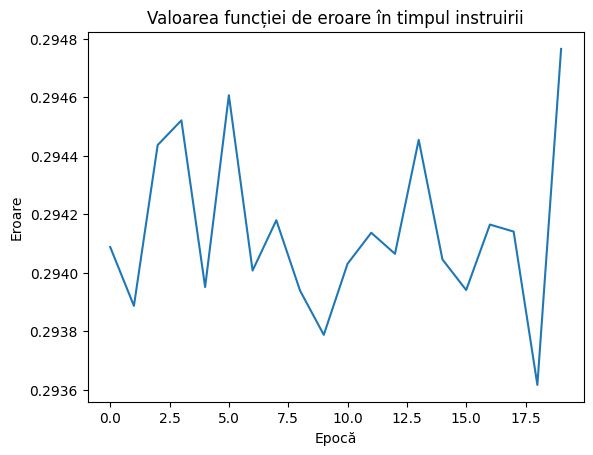

In [96]:
plt.plot(losses)
plt.xlabel('Epoca')
plt.ylabel('Eroare')
plt.title('Valoarea functiei de eroare in timpul instruirii')
plt.show()

In [ ]:
#dupa evolutia graficului de mai sus, putem conchide ca eroarea fluctueaza, dar in general scade pe masura ce modelul invata , deci modelul se antreneaza corect


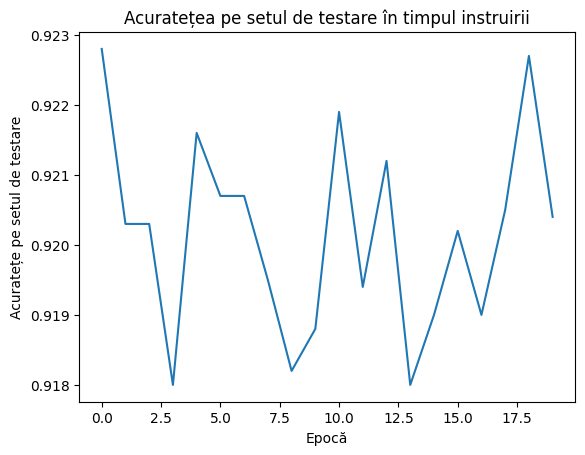

In [97]:
plt.plot(accuracies)
plt.xlabel('Epoca')
plt.ylabel('Acuratete pe setul de testare')
plt.title('Acuratetea pe setul de testare in timpul instruirii')
plt.show()

In [ ]:
# dupa evolutia graficului de mai sus, putem conchide ca fluctuează , dar în general crește în timpul antrenamentului. Acest lucru este un semn bun, deoarece indică faptul că modelul se îmbunătățește în timpul antrenamentului.

## Matricea de confuzie

In [100]:
from sklearn.metrics import confusion_matrix # pentru a calcula matricea de confuzie
import seaborn as sns # pentru a afisa matricea de confuzie sub forma de heatmap


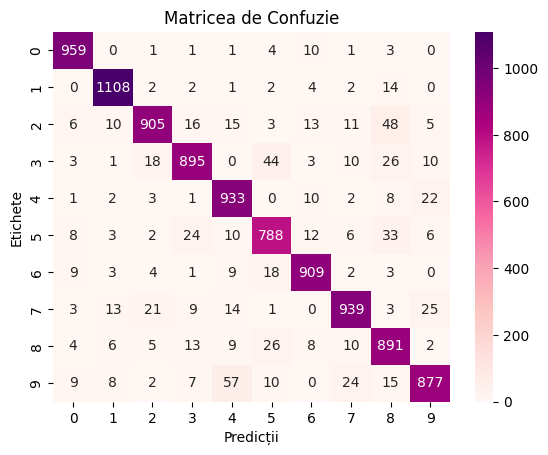

In [103]:
# calculam matricea de confuzie
conf_matrix = confusion_matrix(labels, predictions) # calculam matricea de confuzie pe baza etichetelor si predictiilor
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdPu")  # ANNOT=TRUE pentru a afisa valorile in celule; FMT="D" pentru a afisa valorile ca numere intregi; CMAP="RdPu" pentru a schimba schema de culori
plt.xlabel('Predictii')
plt.ylabel('Etichete')
plt.title('Matricea de Confuzie')
plt.show()